# Sketch Notebook for Model/Obs Comparisons #

In [1]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

## Plot Bathymetry ##

In [2]:
# Stations
iqifs, jqifs = 761, 137
isent, jsent = 707, 145

In [6]:
bathymetry = xr.open_dataset('/data/sallen/results/PRODIGY/ubcSSnBathymetryV17-02_bdc8_1811_3f13.nc')

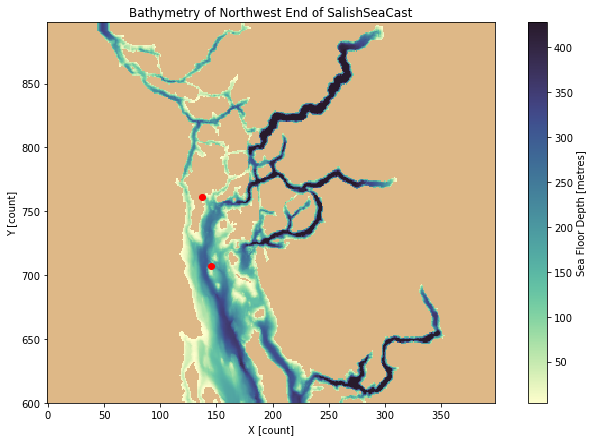

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
mycm = copy.copy(cm.deep)
mycm.set_bad('burlywood')
bathymetry.bathymetry.plot(ax=ax, cmap=mycm);
ax.set_ylim(600, 898)
ax.plot(jsent, isent, 'ro')
ax.plot(jqifs, iqifs, 'ro')
ax.set_aspect(500/440)
ax.set_title('Bathymetry of Northwest End of SalishSeaCast');
fig.savefig('bathynorth.png')

## Plot Time Series Example ##

In [12]:
nitrate = xr.open_dataset('/data/sallen/results/PRODIGY/SalishSeaCast_day_avg_nitrate_20160725_20160804.nc')

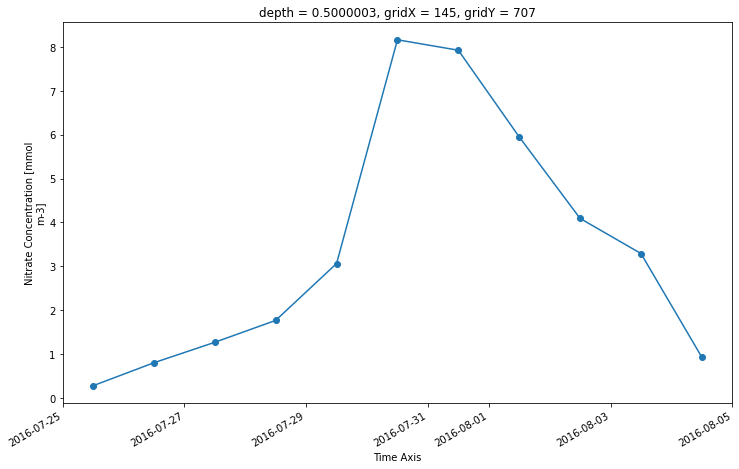

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
nitrate.nitrate[:, 0, isent, jsent].plot(marker='o');

## Plot Water Mass Characteristics ##

In [104]:
def dotheplots(bathymetry, day, kd, isent, jsent, ey, ex, tepmin, tepmax, salmin, salmax, nitmin):
    '''
    bathymetry: xarray of bathmetry file
    day: day of file (so Jul 25 is 0)
    kd: depth index (0 is surface)
    isent, jsent: indexes of Sentry Shoal
    ex, ey: indexes of another point
    tepmin, tepmax: temperature limits
    salmin, salmax: salinity limits
    nitmin: nitrate limit
    '''
    
    fig, axs = plt.subplots(3, 3, figsize=(18, 18))
    
    imin, imax = 650, 800
    jmin, jmax = 100, 215
    
    # bathymetry plots
    bathymetry.bathymetry.plot(ax=axs[0, 0], cmap=mycm);
    axs[0, 0].set_ylim(imin, imax)
    axs[0, 0].set_xlim(jmin, jmax)
    bathymetry.bathymetry.plot(ax=axs[2, 0], cmap=mycm);
    axs[2, 0].set_ylim(imin, imax)
    axs[2, 0].set_xlim(jmin, jmax)
    axs[0, 0].set_title('Bathymetry with Points')
    axs[2, 0].set_aspect(500/440)
    axs[2, 0].set_title('Bathymetry with Cross-sections')
    
    # temperature plot
    dm = xr.open_dataset('/data/sallen/results/PRODIGY/SalishSeaCast_day_avg_physics_20160725_20160804.nc')
    # temperature, masked between the limits
    myarray = np.ma.array(dm.votemper[day, kd, imin:imax, jmin:jmax], 
                      mask= (dm.votemper[day, kd, imin:imax, jmin:jmax] > tepmax) | (dm.votemper[day, kd, imin:imax, jmin:jmax] < tepmin))
    colours = axs[0, 1].pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax), myarray, cmap=cm.thermal, shading='auto')
    fig.colorbar(colours, ax=axs[0, 1])
    axs[0, 1].set_title(f'Temperature at {kd+0.5} m (conservative $^o$C)')
    
    # salinity plot
    # salinity, masked between the limits
    myarray = np.ma.array(dm.vosaline[day, kd, imin:imax, jmin:jmax], 
                      mask= (dm.vosaline[day, kd, imin:imax, jmin:jmax] > salmax) | (dm.vosaline[day, kd, imin:imax, jmin:jmax] < salmin))
    colours = axs[0, 2].pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax), myarray, cmap=cm.haline, shading='auto')
    axs[0, 2].set_title(f'Salinity at {kd+0.5} m (g/kg)')
    fig.colorbar(colours, ax=axs[0, 2])
    
    # nitrate
    ds = xr.open_dataset('/data/sallen/results/PRODIGY/SalishSeaCast_day_avg_nitrate_20160725_20160804.nc')
    myarray = np.ma.array(ds.nitrate[day, kd, imin:imax, jmin:jmax], 
                      mask= ds.nitrate[day, kd, imin:imax, jmin:jmax] < nitmin)
    colours = axs[1, 0].pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax), myarray, cmap=cm.rain, shading='auto')
    fig.colorbar(colours, ax=axs[1, 0])
    axs[1, 0].set_title(f'Nitrate at {kd+0.5} m (uM)')
    
    # intersection of the temperature, salinity and nitrate on this surface
    myarray = np.ma.array(np.ones((imax-imin, jmax-jmin)), 
                      mask= (dm.votemper[day, kd, imin:imax, jmin:jmax] > tepmax) | (dm.votemper[day, kd, imin:imax, jmin:jmax] < tepmin)
                     | (dm.vosaline[day, kd, imin:imax, jmin:jmax] > salmax) | (dm.vosaline[day, kd, imin:imax, jmin:jmax] < salmin)
                          | (ds.nitrate[day, kd, imin:imax, jmin:jmax] < nitmin))
    myarray.mask = myarray.mask | np.isnan(bathymetry.bathymetry[imin-600:imax-600, jmin:jmax])
    colours = axs[1, 1].pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax), myarray, cmap=cm.dense, shading='auto')
    fig.colorbar(colours, ax=axs[1, 1])
    axs[1, 1].set_title(f'Intersection of all three Ranges at {kd+0.5} m');
    
    # create the full 3-D object of this water mass down to 15 m and then plot it in various ways to look at it
    kdd = 15
    watermass = np.ma.array(np.ones((kdd, imax-imin, jmax-jmin)), 
                      mask= (dm.votemper[day, 0:kdd, imin:imax, jmin:jmax] > tepmax) | (dm.votemper[day, 0:kdd, imin:imax, jmin:jmax] < tepmin)
                     | (dm.vosaline[day, 0:kdd, imin:imax, jmin:jmax] > salmax) | (dm.vosaline[day, 0:kdd, imin:imax, jmin:jmax] < salmin)
                           | (ds.nitrate[day, 0:kdd, imin:imax, jmin:jmax] < nitmin)
                       )
    
    # number of depth points with this water mass
    vertsum = watermass.sum(axis=0)
    vertsum.mask = vertsum.mask |  np.isnan(bathymetry.bathymetry[imin-600:imax-600, jmin:jmax])
    colours = axs[1, 2].pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax), vertsum, cmap='plasma', shading='auto')
    fig.colorbar(colours, ax=axs[1, 2])
    axs[1, 2].set_title('Thickness of intersection of all three Ranges (m)');

    # add our points to these plots
    for ax in axs[0]:
        ax.plot(jsent+0.5, isent+0.5, 'ro')
        ax.plot(ex+0.5, ey+0.5, 'mo')
        ax.set_aspect(500/440)
    for ax in axs[1]:
        ax.plot(jsent+0.5, isent+0.5, 'ro')
        ax.plot(ex+0.5, ey+0.5, 'mo')
        ax.set_aspect(500/440)
        
    # vertical crossections
    axs[2, 0].plot([jmin, jmax], [ey+0.5, ey+0.5],  'r-')
    axs[2, 0].plot([ex+0.5, ex+0.5], [imin, imax],  'g-')
    
    # along the red line (across the strait)
    axs[2, 1].pcolormesh(np.arange(jmin+1, jmax), np.arange(15), watermass[:, ey-imin, 1:], shading='auto')
    axs[2, 1].plot(jsent+0.5, 0+0.5, 'r*');
    axs[2, 1].plot(ex+0.5, kd+0.5, 'mo')
    axs[2, 1].invert_yaxis()
    axs[2, 1].set_ylabel('Depth (m)')
    axs[2, 1].set_xlabel('x grid point')
    axs[2, 1].set_title('Location of Water Mass along Red Line');
    
    # along the green line (along the strait)
    axs[2, 2].pcolormesh(np.arange(imin, imax), np.arange(15), watermass[:, :, ex-jmin], shading='auto')
    axs[2, 2].plot(isent+0.5, 0+0.5, 'r*');
    axs[2, 2].plot(ey+0.5, kd+0.5, 'mo');
    axs[2, 2].set_ylabel('Depth (m)')
    axs[2, 2].set_xlabel('y grid point')
    axs[2, 2].invert_yaxis()
    axs[2, 1].set_title('Location of Water Mass along Green Line');
    fig.savefig('exampleplot2.png')

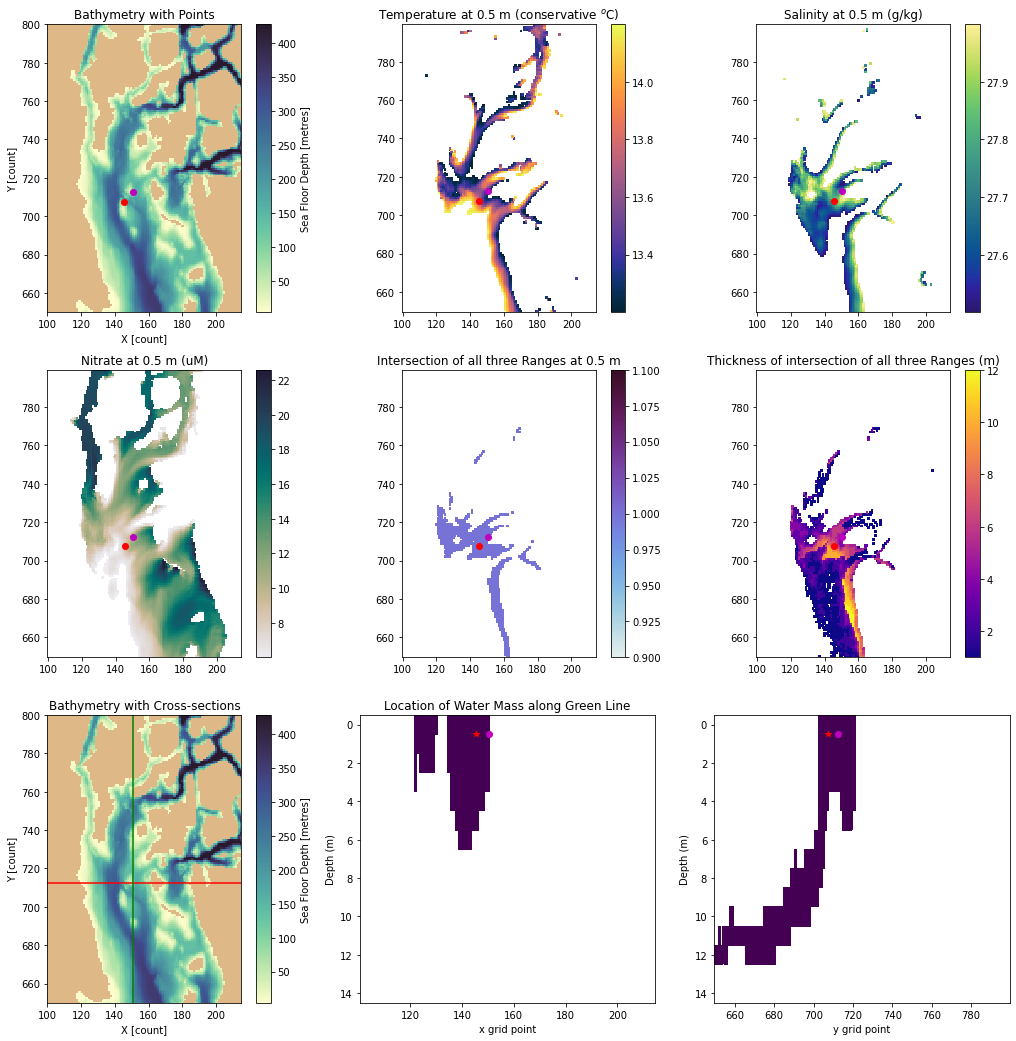

In [105]:
dotheplots(bathymetry, 5, 0, isent, jsent, isent+5, jsent+5, 13.2, 14.2, 27.5, 28, 6)